# Lesson6 ニューラルネットに画像を生成させよう

## 目次

- Section3 テクニック・発展的内容
  - 3.1 Conditional GAN

In [1]:
# MNISTのロードと表示のための関数です。後で使うので読み込んでおいて下さい。
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist(dim=3, data='mnist'):
    img_rows, img_cols = 28, 28
    
    if data == 'mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    if dim == 3:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
        x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
        
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return  x_train, x_test, y_train, y_test

# X_train, _, y_train, _ = load_mnist()
# print(X_train.shape, y_train.shape)

def plot_mnist_conditional(n_ex=10,dim=(2, 5), figsize=(8,4), labels=range(10)):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    label_batch = np.eye(10)[np.arange(10)]
    generated_images = generator.predict([noise, label_batch])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1], i+1)
        img = generated_images[i,:,:, 0]
        plt.imshow(img, cmap='binary')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000, 10)


In [1]:
# グローバル変数の定義
#ラベル数
Nlabel = 46
#潜在変数（Latent Variable）の次元（Noiseの次元）
# LateV = 100
LateV = 50

In [2]:
# ETL6:カタカナ４６文字 or 数字・英大文字・特殊文字 →合計４６文字のロード関数。
import numpy as np
import cv2, pickle
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt
%matplotlib inline

#Nlabel = 46

def load_katakana():
    # データファイルと画像サイズの指定
#     data_file = '/root/userspace/lesson6/master/katakana28.pickle'
    data_file = '/root/userspace/lesson6/master/katakanaETL6_28.pickle'
#     data_file = '/root/userspace/lesson6/master/num-eng-sybETL6_28.pickle'
    im_size = 28
    out_size = Nlabel # ア-ンまでの文字の数
    im_color = 1 # 画像の色空間/グレイスケール
    in_shape = (im_size, im_size, im_color)

    # カタカナ画像のデータセットを読み込む --- (*1)
    data = pickle.load(open(data_file, "rb"))
    # 画像データを変形して0-1の範囲に直す --- (*2)
    y = []
    x = []
    for d in data:
        (num, img) = d
        img = img.astype('float').reshape(
          im_size, im_size, im_color) / 255
        y.append(keras.utils.np_utils.to_categorical(num, out_size))
        x.append(img)
    x = np.array(x)
    y = np.array(y)
    
    return x, y

# X_train, y_train = load_katakana()
# print(X_train.shape, y_train.shape)

Using TensorFlow backend.


In [2]:
# ETL7:ひらがな４６文字データのロード関数。
import numpy as np
import cv2, pickle
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt
%matplotlib inline

#Nlabel = 46

def load_hiragana():
    # データファイルと画像サイズの指定
    data_file = '/root/userspace/lesson6/master/hiragana28.pickle'
#     data_file = '/root/userspace/lesson6/master/hiragana28aug1630.pickle'
    im_size = 28
    out_size = Nlabel # あ-んまでの文字の数
    im_color = 1 # 画像の色空間/グレイスケール
    in_shape = (im_size, im_size, im_color)

    # ひらがな画像のデータセットを読み込む --- (*1)
    data = pickle.load(open(data_file, "rb"))
    # 画像データを変形して0-1の範囲に直す --- (*2)
    y = []
    x = []
    for d in data:
        (num, img) = d
        img = img.astype('float').reshape(
          im_size, im_size, im_color) / 255
        y.append(keras.utils.np_utils.to_categorical(num, out_size))
        x.append(img)
    x = np.array(x)
    y = np.array(y)
    
    return x, y

# X_train, y_train = load_hiragana()
# print(X_train.shape, y_train.shape)

Using TensorFlow backend.


### 3.1 Conditional GAN

Section1では生成する画像のコントロールが出来ませんでした。つまり、数字の1が生成したくてもGeneratorにそうするように制御することが出来ませんでした。

Section3ではラベルを指定することで任意の数字を生成出来るように制御出来るConditional GANを実装して、ニューラルネットに好きな数字を生成させてみましょう。

### 3.1.1 Conditional GANとは？

基本的にはSection1で作成したネットワークと同じです。違いはGeneratorとDiscriminatorのそれぞれにラベルに対応した数字のラベルも入力するところです。

<img src='../figures/gan2.png' alt='gan_2'>

### 3.1.2 Generator

Section1のGANとの違いはランダムノイズに数字のラベル情報を結合しているところです。

以下の実装のようにラベル情報もGeneratorのinputに追加されています。

つまり、要素の100のノイズと要素10のone-hotベクトルのラベル情報を入力として、サイズ28x28でチャンネル1の画像を出力にしています。

In [7]:
##### generator.predict時 #####
# グローバル変数の定義
#ラベル数
Nlabel = 46
#潜在変数（Latent Variable）の次元（Noiseの次元）
# LateV = 100
LateV = 50

In [8]:
##### generator.predict時 #####
from tensorflow.keras.layers import Input, concatenate, Reshape, Dense, Activation, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model

def Generator():
    
    nch=200
    ## 1章のGANとの違い ##
    # ランダムなノイズ
    model_input = Input(shape=[LateV])
    # 0~9のどの数字の画像かのラベル情報
    cond = Input(shape=[Nlabel])
    # 上記2つを結合する
    cond_input = concatenate([model_input, cond], axis=-1) 
    
    x = Dense(nch*14*14, kernel_initializer='glorot_normal')(cond_input) # LateV+Nlabel -> 200*14*14
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape( [14, 14, nch] )(x) # 200*14*14 -> 14x14x200
    x = UpSampling2D(size=(2, 2))(x) # 14x14x200 -> 28x28x200
    x = Conv2D(int(nch/2), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x200 -> 28x28x100
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nch/4), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x100 -> 28x28x50
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x50 -> 28x28x1
    model_output = Activation('sigmoid')(x)
    model = Model([model_input, cond], model_output)
    # model.summary()
    
    return model

### 3.1.3 Discriminator

Section1のGANとの違いは画像に加えて、数字のラベル情報を結合しているところです。

以下の実装のようにラベル情報もDiscriminatorのinputに追加されています。

入力としてはサイズ28x28でチャンネル1の画像と要素10のone-hotベクトルのラベル情報を入力にして、その画像がデータセットにある本物データかどうかを2値で出力します。

注意するのは画像とラベル情報を結合するところです。ラベル情報を28x28x10にreshapeしているところがポイントです。

また、実装に関して今回LambdaというLayerを利用するので説明をします。

Kerasでネットワークを構築するときにLayerに定義された層以外を使いたいときは、Lambdaというlayerを用いてラップする必要があります。
例えば、値を2乗するLayerを追加するときは以下のようにしてLambdaでラップします。

```
Lambda(lambda x: x ** 2)
```

In [4]:
from tensorflow.keras.layers import Input, concatenate, Lambda, Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def Discriminator(shape, dropout_rate=0.25, opt=Adam(lr=1e-4)):
    
    ## 1章のGANとの違い ##
    model_input = Input(shape=shape)
    cond = Input(shape=[Nlabel])
    
    # ここでラベル情報をreshape
    cond_reshape = Reshape( [1, 1, Nlabel] )(cond) # 1x1xNlabel
    cond_reshape = Lambda(lambda x: K.ones([28, 28, Nlabel])*x)(cond_reshape) # 1x1xNlabel -> 28x28xNlabel
    cond_input = concatenate([model_input, cond_reshape], axis=-1) # 28x28x(Nlabel+1)
    
    x = Conv2D(256, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(cond_input) # 28x28x(Nlabel+1) -> 14x14x256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(x) # 14x14x256 -> 7x7x512
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x) # 7x7x512 -> 7*7*512
    x = Dense(1024)(x) # 7*7*512 -> 1024
    x = LeakyReLU(0.2)(x)
    x = Dense(512)(x) # 1024 -> 512
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x) # 512 -> 256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    model_output = Dense(2,activation='softmax')(x) # 256 -> 2
    model = Model([model_input, cond], model_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

Instructions for updating:
Colocations handled automatically by placer.


### 3.1.4 GANの学習

学習自体はSection1のGANとほとんど同じです。

In [5]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def combined_network(generator, discriminator, opt=Adam(lr=1e-3)):
    gan_input = Input(shape=[LateV])
    cond = Input(shape=[Nlabel])
    x = generator([gan_input, cond])
    gan_output = discriminator([x, cond])
    model = Model([gan_input, cond], gan_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

In [6]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [7]:
from tqdm import tqdm

def train(step=3000, BATCH_SIZE=128):
    
    sum_d = 0
    sum_g = 0
    interval = 500
    for e in tqdm(range(step)):  
        
        image_indexes = np.random.randint(0,X_train.shape[0],size=BATCH_SIZE)
        image_batch = X_train[image_indexes,:,:,:]  
        label_batch = y_train[image_indexes]  
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,LateV])
        generated_images = generator.predict([noise_gen, label_batch])
        
        make_trainable(discriminator,True)
        
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        label_batch = np.concatenate((label_batch, label_batch))
        
        
        d_loss = discriminator.train_on_batch([X, label_batch], y)
        
        make_trainable(discriminator,False)
    
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,LateV])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        label_batch2 = np.random.randint(0, Nlabel, size=BATCH_SIZE)
        label_batch2 = np.eye(Nlabel)[label_batch2]
             
        g_loss = GAN.train_on_batch([noise_tr, label_batch2], y2 )
        
        # 進捗の表示
        if (e+1) % interval == 0:
            sum_d /= interval
            sum_g /= interval
            print ("%d [D loss: %f] [G loss: %f]" % (e+1, sum_d, sum_g))
            sum_d = 0
            sum_g = 0
        else:
            sum_d += d_loss
            sum_g += g_loss

### 3.1.5 MNISTによる学習

In [8]:
# network 
# X_train, _, y_train, _ = load_mnist()
# X_train, y_train = load_katakana()  # ETL6:カタカナ４６文字 or 数字・英大文字・特殊文字 →合計４６文字
X_train, y_train = load_hiragana() # ETL7:ひらがな４６文字

generator = Generator()
discriminator = Discriminator(X_train.shape[1:])
# discriminator = Discriminator(X_train.shape[1:], dropout_rate=0.5)
make_trainable(discriminator, False)
GAN = combined_network(generator, discriminator)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
print(X_train.shape, y_train.shape)

(16100, 28, 28, 1) (16100, 46)


In [29]:
train(step=5000)

 10%|█         | 500/5000 [03:14<28:53,  2.60it/s]

500 [D loss: 0.373995] [G loss: 1.606499]


 20%|██        | 1000/5000 [06:28<26:00,  2.56it/s]

1000 [D loss: 0.370197] [G loss: 1.671145]


 30%|███       | 1500/5000 [09:42<22:44,  2.56it/s]

1500 [D loss: 0.361964] [G loss: 1.671640]


 40%|████      | 2000/5000 [12:56<19:18,  2.59it/s]

2000 [D loss: 0.321625] [G loss: 1.580117]


 50%|█████     | 2500/5000 [16:10<16:08,  2.58it/s]

2500 [D loss: 0.325546] [G loss: 1.621551]


 60%|██████    | 3000/5000 [19:24<12:57,  2.57it/s]

3000 [D loss: 0.346660] [G loss: 1.820604]


 70%|███████   | 3500/5000 [22:38<09:43,  2.57it/s]

3500 [D loss: 0.279043] [G loss: 1.412592]


 80%|████████  | 4000/5000 [25:53<06:30,  2.56it/s]

4000 [D loss: 0.317026] [G loss: 2.064881]


 90%|█████████ | 4500/5000 [29:07<03:14,  2.57it/s]

4500 [D loss: 0.323637] [G loss: 2.105698]


100%|██████████| 5000/5000 [32:22<00:00,  2.57it/s]

5000 [D loss: 0.307546] [G loss: 2.201986]


In [30]:
# GAN.save('/root/userspace/lesson6/master/GAN_model.h5')
generator.save('/root/userspace/lesson6/master/generator_model.h5')

In [9]:
##### generator.predict時 #####
# generator = Generator()
# generator.load_weights('/root/userspace/lesson6/master/generator_NUMENG15E6LV50.h5')
# generator.load_weights('/root/userspace/lesson6/master/generator_NUMENG38000.h5')
generator3 = Generator()
generator4 = Generator()
generator5 = Generator()
# GAN.load_weights('/root/userspace/lesson6/master/GAN_model.h5')
# generator.load_weights('/root/userspace/lesson6/master/generator_kata2ETL6.h5')
# generator3.load_weights('/root/userspace/lesson6/master/generator_NUMENG2ETL6.h5')
# generator4.load_weights('/root/userspace/lesson6/master/generator_kata2ETL6.h5')
# generator5.load_weights('/root/userspace/lesson6/master/generator_hira2ETL7.h5')
generator3.load_weights('/root/userspace/lesson6/master/generator_NUMENG35E6LV50.h5')
generator4.load_weights('/root/userspace/lesson6/master/generator_kata5E6LV50.h5')
generator5.load_weights('/root/userspace/lesson6/master/generator_hira45E7LV50.h5')

### 3.1.6 手書き文字の生成

それではニューラルネットに画像を生成させてみましょう。順に0~9が並ぶことが確認出来ると思います。

In [10]:
##### generator.predict時 #####
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image as pil_image

# load inception v3 model
inception_model = InceptionV3()

# 画像リサイズ
def resize_imgs(x):
    x_list = []
    for i in range(x.shape[0]):
        img = image.array_to_img(x[i, :, :, :].reshape(28, 28, -1))
        # 以下のリサイズ処理を通すと[0,1]の範囲のデータが[0,255]に変換される
        # preprocess_inputは[0,255]の入力データが必要なので、問題なし
        img = img.resize(size=(299, 299), resample=pil_image.LANCZOS)
        x_list.append(image.img_to_array(img))
    return np.array(x_list)

# inception score計算
def inception_score(x, resizer, pre_images_incept_predict=None):
    x = resizer(x)
    r = inception_model.predict(preprocess_input(x)) # r has the probabilities for all classes
    r = r if pre_images_incept_predict is None else np.concatenate([pre_images_incept_predict, r], axis=0)

    p_y = np.mean(r, axis=0) # p(y)
    e = r*np.log(r/p_y) # p(y|x)log(P(y|x)/P(y))
    e = np.sum(e, axis=1) # KL(x) = Σ_y p(y|x)log(P(y|x)/P(y))
    e = np.mean(e, axis=0)
    return np.exp(e)   #, r # Inception score, Inception V3のpredict結果

# inception score計算：pre_images_incept_predictに指定したInceptionV3のpredictと結合したinception scoreを出力
def calc_inception_score(images, pre_images_incept_predict=None):
    images = np.tile(images, (1, 1, 1, 3)) # shape=(, 28, 28, 1) --> (, 28, 28, 3)
    return inception_score(images, resize_imgs, pre_images_incept_predict)

In [11]:
##### generator.predict時 #####
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_imgs_conditional(n_ex=Nlabel):
    noise = np.random.uniform(0,1,size=[n_ex,LateV])
    label_batch = np.eye(Nlabel)[np.arange(Nlabel)]
    generated_images = generator.predict([noise, label_batch])
    return generated_images
def plot_conditional(dim=(10, 5), figsize=(16,32), labels=range(Nlabel)):
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1], i+1)
        img = generated_images[i,:,:, 0]
        plt.imshow(img, cmap='binary')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

数字英字：g3imgs.shape= (48, 28, 28, 1) ***** inception_score(num=46) =  2.367852
カタカナ：g4imgs.shape= (53, 28, 28, 1) ***** inception_score(num=46) =  2.2655027
ひらがな：g5imgs.shape= (39, 28, 28, 1) ***** inception_score(num=46) =  1.9604722


<Figure size 5040x5040 with 0 Axes>

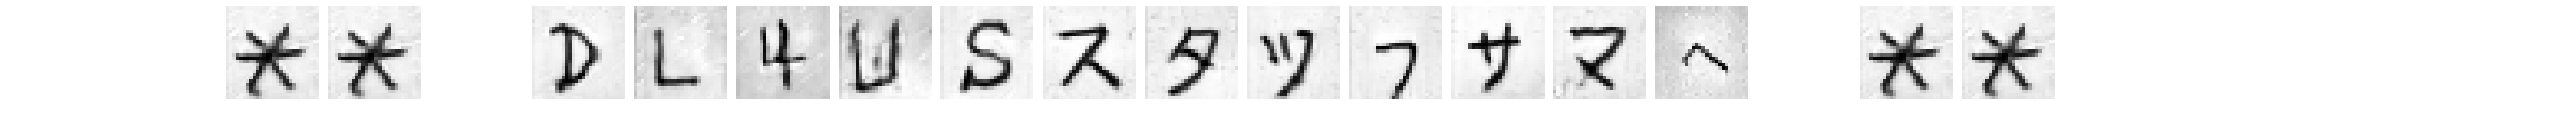

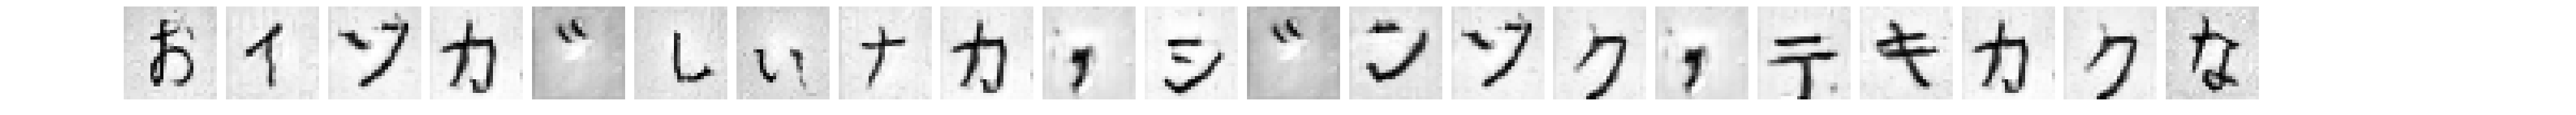

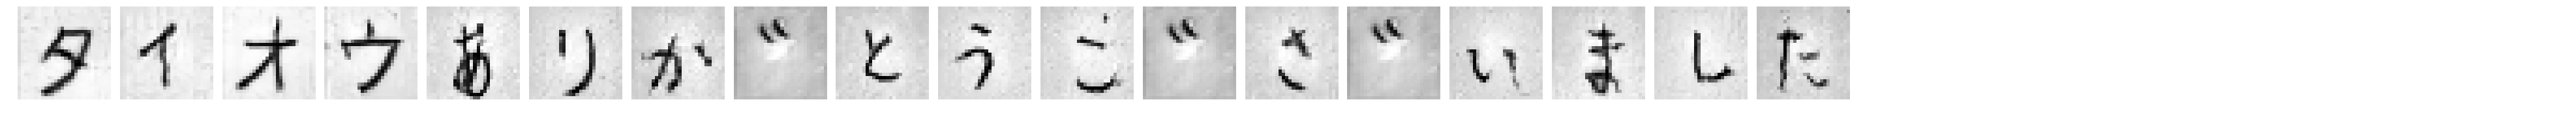

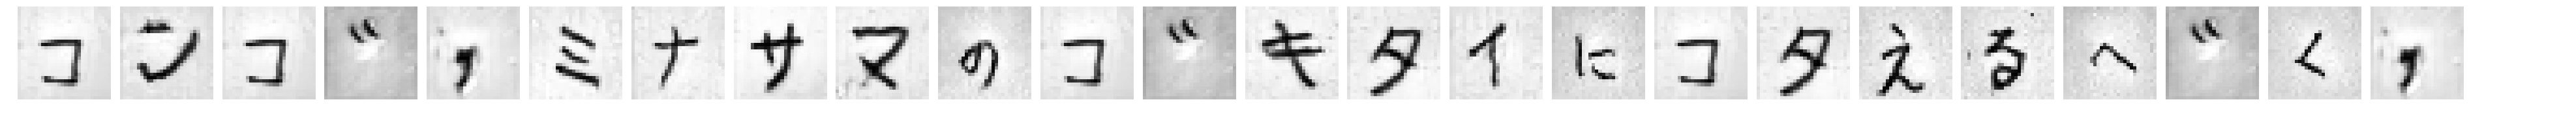

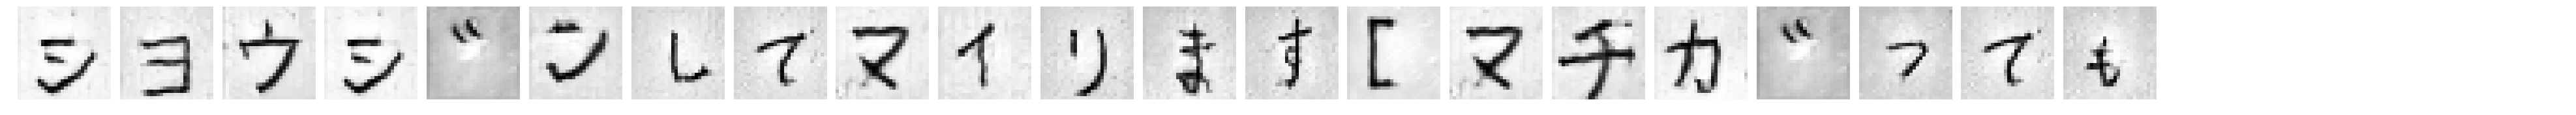

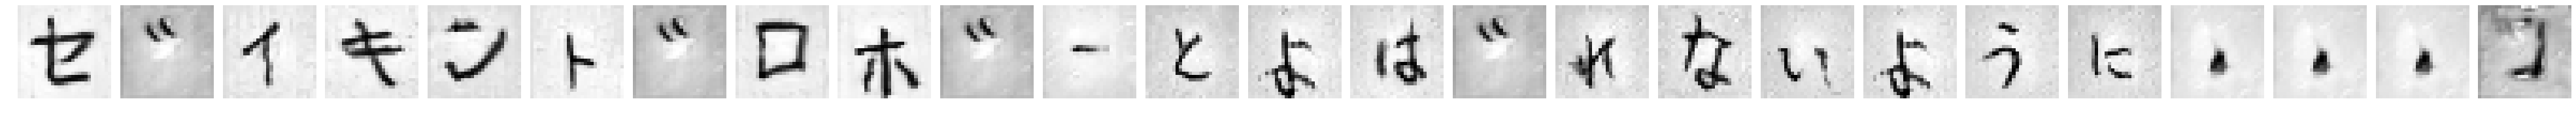

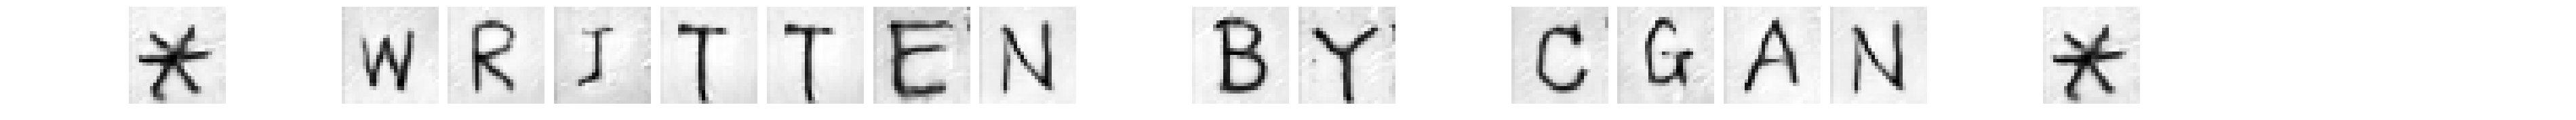

<Figure size 5040x5040 with 0 Axes>

In [33]:
##### generator.predict時 #####
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
    
def gen_imgs_conditional2(generator):
    noise = np.random.uniform(0,1,size=[Nlabel,LateV])
    label_batch = np.eye(Nlabel)[np.arange(Nlabel)]
#     print(label_batch.shape)
    generated_images = generator.predict([noise, label_batch])
#     print(generated_images.shape)
    return generated_images

def plot_conditional2(masu, dim=(18, 25), figsize=(70,70)):
#     fig = plt.figure(figsize=figsize)
    fig = plt.figure(figsize=figsize, facecolor="white")
    fig.subplots_adjust(hspace=0.05, wspace=0.1)
    k3 = 0
    k4 = 0
    k5 = 0
    endflg = 0
    rnum = 18
    cnum = 25
    img_white = np.ones((300,300),np.uint8)*255
    for i in range(rnum):      # 行のループ
#         fig = plt.figure(figsize=figsize)
        fig = plt.figure(figsize=figsize, facecolor="white")
        fig.subplots_adjust(hspace=0.05, wspace=0.1)

        if endflg == 1:
            break
        for j in range(cnum):  # １行内の文字ループ
#             if masu[i, j] == 1:
#                 break        # １行改行
            if masu[i, j] == 2:
                endflg = 1
                break        # 終了
            plt.subplot(dim[0],dim[1], j+1)
            if masu[i, j] == 0:      # 下記（3,4,5）をせず、白画像を表示して1文字分スキップ
                plt.plot(), plt.imshow(img_white, cmap='gray', vmin=0, vmax=255)
                plt.axis('off')
            elif masu[i, j] == 3:   
                img = g3imgs[k3,:,:, 0]
                k3 += 1
                plt.imshow(img, cmap='binary')
                plt.axis('off')
            elif masu[i, j] == 4:
                img = g4imgs[k4,:,:, 0]
                k4 += 1
                plt.imshow(img, cmap='binary')
                plt.axis('off')
            elif masu[i, j] == 5:
                img = g5imgs[k5,:,:, 0]
                k5 += 1
                plt.imshow(img, cmap='binary')
                plt.axis('off')
        plt.show()

# # データ作成①
# # ETL6:数字(10)、英大文字(26)、特殊文字(10)：合計46文字のCGANによる生成、及び文字の再連結によるメッセージの作成。
# # [36,36,36,44,36, 36,36,40,41,44, 44,44,37,39,44, 37,44,37,44,37, 44,44,44,42,10, 18,43,44,44,44,
# # 44,44,44,44,44, 44,42,27,10,18, 28,14,43,40,41, 2,0,2,0,38, 1,38,9,36,32, 27,18,29,29,14, 23,11,34,12,16, 10,23,36]
# g3img46 = gen_imgs_conditional2(generator3)
# incep_score3 = calc_inception_score(g3img46)
# g3imgs = np.concatenate([[g3img46[36,:]], [g3img46[36,:]], [g3img46[36,:]], [g3img46[44,:]], [g3img46[36,:]],
#                          [g3img46[36,:]], [g3img46[36,:]], [g3img46[40,:]], [g3img46[41,:]], [g3img46[44,:]],
#                          [g3img46[44,:]], [g3img46[44,:]], [g3img46[37,:]], [g3img46[39,:]], [g3img46[44,:]],
#                          [g3img46[37,:]], [g3img46[44,:]], [g3img46[37,:]], [g3img46[44,:]], [g3img46[37,:]],
#                          [g3img46[44,:]], [g3img46[44,:]], [g3img46[44,:]], [g3img46[42,:]], [g3img46[10,:]],
#                          [g3img46[18,:]], [g3img46[43,:]], [g3img46[44,:]], [g3img46[44,:]], [g3img46[44,:]],
#                          [g3img46[44,:]], [g3img46[44,:]], [g3img46[44,:]], [g3img46[44,:]], [g3img46[44,:]],
#                          [g3img46[44,:]], [g3img46[42,:]], [g3img46[27,:]], [g3img46[10,:]], [g3img46[18,:]],
#                          [g3img46[28,:]], [g3img46[14,:]], [g3img46[43,:]], [g3img46[40,:]], [g3img46[41,:]],
#                          [g3img46[2,:]], [g3img46[0,:]], [g3img46[2,:]], [g3img46[0,:]], [g3img46[38,:]],
#                          [g3img46[1,:]], [g3img46[38,:]], [g3img46[9,:]], [g3img46[36,:]], [g3img46[32,:]],
#                          [g3img46[27,:]], [g3img46[18,:]], [g3img46[29,:]], [g3img46[29,:]], [g3img46[14,:]],
#                          [g3img46[23,:]], [g3img46[11,:]], [g3img46[34,:]], [g3img46[12,:]], [g3img46[16,:]],
#                          [g3img46[10,:]], [g3img46[23,:]], [g3img46[36,:]]], axis=0)
# print('数字英字：g3imgs.shape=', g3imgs.shape, '***** inception_score(num=46) = ', incep_score3)

# # ETL6:カタカナ46文字のCGANによる生成、及び文字の再連結によるメッセージの作成。
# # [5,45,11,35,11, 37,2,31,5,18, 1,23,45,10,10, 9,14,15,18,4, 35,6,37,2,15, 1,11,15,1,28, 45,31,5,11,37, 2,27,
# # 1,30,1, 11,37,2,15,1, 28,45,10,10,35, 12,26,42]
# g4img46 = gen_imgs_conditional2(generator4)
# incep_score4 = calc_inception_score(g4img46)
# g4imgs = np.concatenate([[g4img46[5,:]], [g4img46[45,:]], [g4img46[11,:]], [g4img46[35,:]],[g4img46[11,:]],
#                          [g4img46[37,:]], [g4img46[2,:]], [g4img46[31,:]], [g4img46[5,:]],[g4img46[18,:]],
#                          [g4img46[1,:]], [g4img46[23,:]], [g4img46[45,:]], [g4img46[10,:]],[g4img46[10,:]],
#                          [g4img46[9,:]], [g4img46[14,:]], [g4img46[15,:]], [g4img46[18,:]],[g4img46[4,:]],
#                          [g4img46[35,:]], [g4img46[6,:]], [g4img46[37,:]], [g4img46[2,:]],[g4img46[15,:]],
#                          [g4img46[1,:]], [g4img46[11,:]], [g4img46[15,:]], [g4img46[1,:]],[g4img46[28,:]],
#                          [g4img46[45,:]], [g4img46[31,:]], [g4img46[5,:]], [g4img46[11,:]],[g4img46[37,:]],
#                          [g4img46[2,:]], [g4img46[27,:]], [g4img46[1,:]], [g4img46[30,:]],[g4img46[1,:]],
#                          [g4img46[11,:]], [g4img46[37,:]], [g4img46[2,:]], [g4img46[15,:]],[g4img46[1,:]],
#                          [g4img46[28,:]], [g4img46[45,:]], [g4img46[10,:]], [g4img46[10,:]],[g4img46[35,:]],
#                          [g4img46[12,:]], [g4img46[26,:]], [g4img46[42,:]]], axis=0)
# print('カタカナ：g4imgs.shape=', g4imgs.shape, '***** inception_score(num=46) = ', incep_score4)

# # ETL7:ひらがな46文字のCGANによる生成、及び文字の再連結によるメッセージの作成。
# # [10,45,28,30,18, 3,18,7,41,18, 0,39,5,19,2, 24,1,42,1,42, 20,9,19,34,0, 17,15,8,19,20, 45,19,5,9,9, 30,18,9,41,15, 24,25,
# # 10,45,24, 4,5,8,18,12, 0,39,5,19,2, 9,41,5,38,25, 18,11,30,12,30, 18,21,15,8,19, 30,15,3,18,7, 15,10,1,14,11, 18,18,6,41,25, 34,23,37,39] 
# g5img46 = gen_imgs_conditional2(generator5)
# incep_score5 = calc_inception_score(g5img46)
# g5imgs = np.concatenate([[g5img46[10,:]], [g5img46[45,:]], [g5img46[28,:]], [g5img46[30,:]], [g5img46[18,:]],
#                          [g5img46[3,:]], [g5img46[18,:]], [g5img46[7,:]], [g5img46[41,:]], [g5img46[18,:]],
#                          [g5img46[0,:]], [g5img46[39,:]], [g5img46[5,:]], [g5img46[19,:]], [g5img46[2,:]],
#                          [g5img46[24,:]], [g5img46[1,:]], [g5img46[42,:]], [g5img46[1,:]], [g5img46[42,:]],
#                          [g5img46[20,:]], [g5img46[9,:]], [g5img46[19,:]], [g5img46[34,:]], [g5img46[0,:]],
#                          [g5img46[17,:]], [g5img46[15,:]], [g5img46[8,:]], [g5img46[19,:]], [g5img46[20,:]],
#                          [g5img46[45,:]], [g5img46[19,:]], [g5img46[5,:]], [g5img46[9,:]], [g5img46[9,:]],
#                          [g5img46[30,:]], [g5img46[18,:]], [g5img46[9,:]], [g5img46[41,:]], [g5img46[15,:]],
#                          [g5img46[24,:]], [g5img46[25,:]], [g5img46[10,:]], [g5img46[45,:]], [g5img46[24,:]],
#                          [g5img46[4,:]], [g5img46[5,:]], [g5img46[8,:]], [g5img46[18,:]], [g5img46[12,:]],
#                          [g5img46[0,:]], [g5img46[39,:]], [g5img46[5,:]], [g5img46[19,:]], [g5img46[2,:]],
#                          [g5img46[9,:]], [g5img46[41,:]], [g5img46[5,:]], [g5img46[38,:]], [g5img46[25,:]],
#                          [g5img46[18,:]], [g5img46[11,:]], [g5img46[30,:]], [g5img46[12,:]], [g5img46[30,:]],
#                          [g5img46[18,:]], [g5img46[21,:]], [g5img46[15,:]], [g5img46[8,:]], [g5img46[19,:]],
#                          [g5img46[30,:]], [g5img46[15,:]], [g5img46[3,:]], [g5img46[18,:]], [g5img46[7,:]],
#                          [g5img46[15,:]], [g5img46[10,:]], [g5img46[1,:]], [g5img46[14,:]], [g5img46[11,:]],
#                          [g5img46[18,:]], [g5img46[18,:]], [g5img46[6,:]], [g5img46[41,:]], [g5img46[25,:]],
#                          [g5img46[34,:]], [g5img46[23,:]], [g5img46[37,:]], [g5img46[39,:]]], axis=0)
# print('ひらがな：g5imgs.shape=', g5imgs.shape, '***** inception_score(num=46) = ', incep_score5)

# #原稿マス目上の文字種管理によるメッセージ作成（0:空欄、2:メッセージ終了、3:数字・英大文字・特殊文字、4:カタカナ、5:ひらがな）
# #                 0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4
# masu = np.array([[0,0,3,3,3,0,4,4,4,4,4,3,4,4,0,3,3,3,0,0,0,0,0,0,0],
#                  [0,3,4,4,5,5,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#                  [4,4,4,4,5,5,3,4,4,5,5,5,5,5,5,5,5,3,5,5,0,0,0,0,0],
#                  [4,4,4,3,4,3,4,4,3,4,4,4,4,3,4,5,4,3,0,0,0,0,0,0,0],
#                  [5,5,5,5,4,4,4,4,5,5,5,5,5,5,5,5,5,3,3,0,0,0,0,0,0],
#                  [5,5,5,5,5,5,5,5,3,5,5,5,5,5,3,0,0,0,0,0,0,0,0,0,0],
#                  [4,4,5,5,5,5,5,5,3,5,3,5,0,5,5,5,3,5,5,0,0,0,0,0,0],
#                  [5,5,5,5,5,3,3,3,3,5,3,4,4,4,4,3,5,5,5,0,0,0,0,0,0],
#                  [4,4,5,5,3,4,4,3,4,4,5,4,4,4,4,5,3,5,5,3,0,0,0,0,0],
#                  [5,5,4,4,5,5,5,5,3,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#                  [5,5,5,5,3,5,5,5,3,3,3,3,3,3,3,3,5,5,0,0,0,0,0,0,0],
#                  [0,0,0,0,0,0,0,0,0,0,0,0,3,4,4,4,4,5,5,3,0,0,0,0,0],
#                  [0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,0,0,0,0,0],
#                  [0,3,0,3,3,3,3,3,3,3,0,3,3,0,3,3,3,3,0,3,0,0,0,0,2]])

# データ作成②
# ETL6:数字(10)、英大文字(26)、特殊文字(10)：合計46文字のCGANによる生成、及び文字の再連結によるメッセージの作成。
# [36,36,13,21,4, 30,28,36,36,44, 37,44,37,     44,44,44,44,37, 44,44,37,44,40, 44,44,44,44,38,
# 44,39,39,39,41, 36,32,27,18,29, 29,14,23,11,34, 12,16,10,23,36]
g3img46 = gen_imgs_conditional2(generator3)
incep_score3 = calc_inception_score(g3img46)
g3imgs = np.concatenate([[g3img46[36,:]], [g3img46[36,:]], [g3img46[13,:]], [g3img46[21,:]], [g3img46[4,:]],
                         [g3img46[30,:]], [g3img46[28,:]], [g3img46[36,:]], [g3img46[36,:]], [g3img46[44,:]],
                         [g3img46[37,:]], [g3img46[44,:]], [g3img46[37,:]],
                         [g3img46[44,:]], [g3img46[44,:]], [g3img46[44,:]], [g3img46[44,:]], [g3img46[37,:]],
                         [g3img46[44,:]], [g3img46[44,:]], [g3img46[37,:]], [g3img46[44,:]], [g3img46[40,:]],
                         [g3img46[44,:]], [g3img46[44,:]], [g3img46[44,:]], [g3img46[44,:]], [g3img46[38,:]],
                         [g3img46[44,:]], [g3img46[39,:]], [g3img46[39,:]], [g3img46[39,:]], [g3img46[41,:]],
                         [g3img46[36,:]], [g3img46[32,:]], [g3img46[27,:]], [g3img46[18,:]], [g3img46[29,:]],
                         [g3img46[29,:]], [g3img46[14,:]], [g3img46[23,:]], [g3img46[11,:]], [g3img46[34,:]],
                         [g3img46[12,:]], [g3img46[16,:]], [g3img46[10,:]], [g3img46[23,:]], [g3img46[36,:]]], axis=0)
print('数字英字：g3imgs.shape=', g3imgs.shape, '***** inception_score(num=46) = ', incep_score3)

# ETL6:カタカナ46文字のCGANによる生成、及び文字の再連結によるメッセージの作成。
# [12,15,17,27,10, 30,1,14,5,20, 5,11,45,14,7, 18,6,5,7,15, 1,4,2,     9,45,9,31, 
# 20,10,30,9,6, 15,1,9,15,11, 37,2,11,45,30, 1,30,16,5,13, 1,6,45,19,42, 29]
g4img46 = gen_imgs_conditional2(generator4)
incep_score4 = calc_inception_score(g4img46)
g4imgs = np.concatenate([[g4img46[12,:]], [g4img46[15,:]], [g4img46[17,:]], [g4img46[27,:]],[g4img46[10,:]],
                         [g4img46[30,:]], [g4img46[1,:]], [g4img46[14,:]], [g4img46[5,:]],[g4img46[20,:]],
                         [g4img46[5,:]], [g4img46[11,:]], [g4img46[45,:]], [g4img46[14,:]],[g4img46[7,:]],
                         [g4img46[18,:]], [g4img46[6,:]], [g4img46[5,:]], [g4img46[7,:]],[g4img46[15,:]],
                         [g4img46[1,:]], [g4img46[4,:]], [g4img46[2,:]],
                         [g4img46[9,:]], [g4img46[45,:]], [g4img46[9,:]],[g4img46[31,:]],
                         [g4img46[20,:]], [g4img46[10,:]], [g4img46[30,:]], [g4img46[9,:]],[g4img46[6,:]],
                         [g4img46[15,:]], [g4img46[1,:]], [g4img46[9,:]], [g4img46[15,:]],[g4img46[11,:]],
                         [g4img46[37,:]], [g4img46[2,:]], [g4img46[11,:]], [g4img46[45,:]],[g4img46[30,:]],
                         [g4img46[1,:]], [g4img46[30,:]], [g4img46[16,:]], [g4img46[5,:]],[g4img46[13,:]],
                         [g4img46[1,:]], [g4img46[6,:]], [g4img46[45,:]], [g4img46[19,:]], [g4img46[42,:]],
                         [g4img46[29,:]]], axis=0)
print('カタカナ：g4imgs.shape=', g4imgs.shape, '***** inception_score(num=46) = ', incep_score4)

# ETL7:ひらがな46文字のCGANによる生成、及び文字の再連結によるメッセージの作成。
# [28,4,11,1,20,      0,39,5, 19,2,9,10,1, 30,11,15,24,21, 3,40,28,7,11, 18,39,30,12,17,
# 18,34,19,37,25, 41,20,1,37,2, 21]
g5img46 = gen_imgs_conditional2(generator5)
incep_score5 = calc_inception_score(g5img46)
g5imgs = np.concatenate([[g5img46[28,:]], [g5img46[4,:]], [g5img46[11,:]], [g5img46[1,:]], [g5img46[20,:]],
                         [g5img46[0,:]], [g5img46[39,:]], [g5img46[5,:]],
                         [g5img46[19,:]], [g5img46[2,:]], [g5img46[9,:]], [g5img46[10,:]], [g5img46[1,:]],
                         [g5img46[30,:]], [g5img46[11,:]], [g5img46[15,:]], [g5img46[24,:]], [g5img46[21,:]],
                         [g5img46[3,:]], [g5img46[40,:]], [g5img46[28,:]], [g5img46[7,:]], [g5img46[11,:]],
                         [g5img46[18,:]], [g5img46[39,:]], [g5img46[30,:]], [g5img46[12,:]], [g5img46[17,:]],
                         [g5img46[18,:]], [g5img46[34,:]], [g5img46[19,:]], [g5img46[37,:]], [g5img46[25,:]],
                         [g5img46[41,:]], [g5img46[20,:]], [g5img46[1,:]], [g5img46[37,:]], [g5img46[2,:]],
                         [g5img46[21,:]]], axis=0)
print('ひらがな：g5imgs.shape=', g5imgs.shape, '***** inception_score(num=46) = ', incep_score5)

#原稿マス目上の文字種管理によるメッセージ作成（0:空欄、2:メッセージ終了、3:数字・英大文字・特殊文字、4:カタカナ、5:ひらがな）
#                 0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4
masu = np.array([[0,0,3,3,0,3,3,3,3,3,4,4,4,4,4,4,5,0,3,3,0,0,0,0,0],
                 [0,5,4,4,4,3,5,5,4,4,3,4,3,4,4,4,3,4,4,4,4,5,0,0,0],
                 [4,4,4,4,5,5,5,3,5,5,5,3,5,3,5,5,5,5,0,0,0,0,0,0,0],
                 [4,4,4,3,3,4,4,4,4,5,4,3,4,4,4,5,4,4,5,5,5,3,5,3,0],
                 [4,4,4,4,3,4,5,5,4,4,5,5,5,3,4,4,4,3,5,5,5,0,0,0,0],
                 [4,3,4,4,4,4,3,4,4,3,3,5,5,5,3,5,5,5,5,5,5,3,3,3,3],
                 [0,3,0,3,3,3,3,3,3,3,0,3,3,0,3,3,3,3,0,3,0,0,0,0,2]])

plot_conditional2(masu)

In [7]:
import numpy as np
array = np.array([[1, 2, 3], [4, 5, 6]])
print(array) 
# print(array.shape)
array1=array
print(array1.shape)
array2 = np.array([[7, 8, 9], [4, 5, 6]])
# array2=array[np.newaxis,:]
print(array2.shape)
print(array2)
array3=np.concatenate([[array1], [array2]], axis=0)
print(array3.shape)
print(array3)

[[1 2 3]
 [4 5 6]]
(2, 3)
(2, 3)
[[7 8 9]
 [4 5 6]]
(2, 2, 3)
[[[1 2 3]
  [4 5 6]]

 [[7 8 9]
  [4 5 6]]]


***** inception_score(num=46) =  2.5041616
***** inception_score(num=46) =  2.4079294
***** inception_score(num=46) =  2.6312778
***** inception_score(num=46) =  2.6971188
***** inception_score(num=46) =  2.3678207
***** inception_score(num=46) =  2.4693952
***** inception_score(num=46) =  2.3693104
***** inception_score(num=46) =  2.2120616
***** inception_score(num=46) =  2.4019647
***** inception_score(num=46) =  2.2297986
***** inception_score(num=46) =  2.1818893
***** inception_score(num=46) =  2.7566237
***** inception_score(num=46) =  2.6239564
***** inception_score(num=46) =  2.8468637
***** inception_score(num=46) =  2.2772746
***** inception_score(num=46) =  2.5823333
***** inception_score(num=46) =  2.0409474
***** inception_score(num=46) =  2.493715
***** inception_score(num=46) =  2.3232796
***** inception_score(num=46) =  2.508929
***** inception_score(num=46) =  2.6553514
***** inception_score(num=46) =  2.353779
***** inception_score(num=46) =  2.4114487
***** inceptio

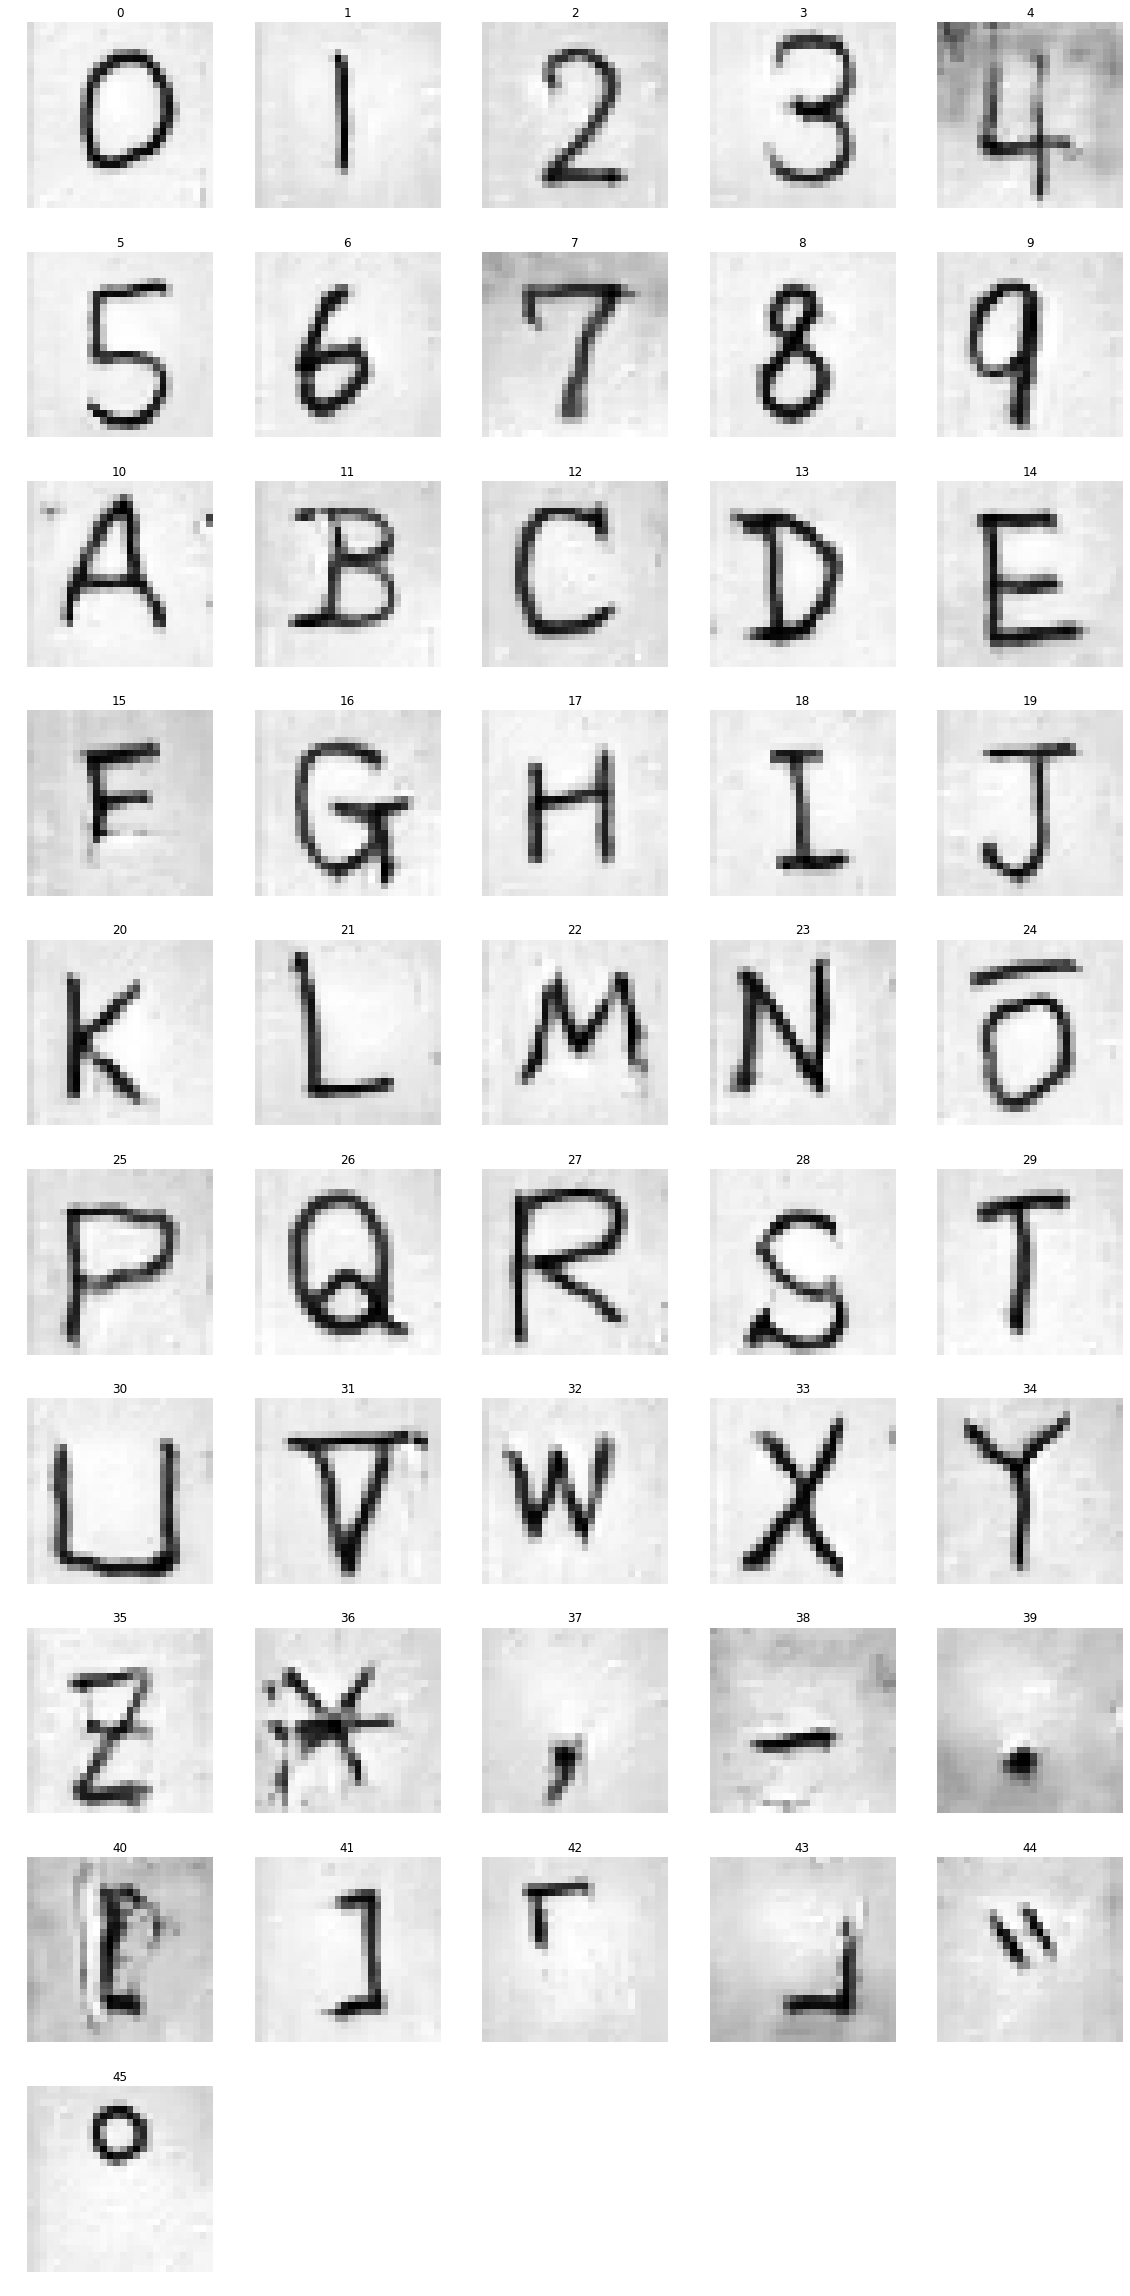


reps= 100 ***** Min score ***** inception_score(num= 46 ) =  2.0409474


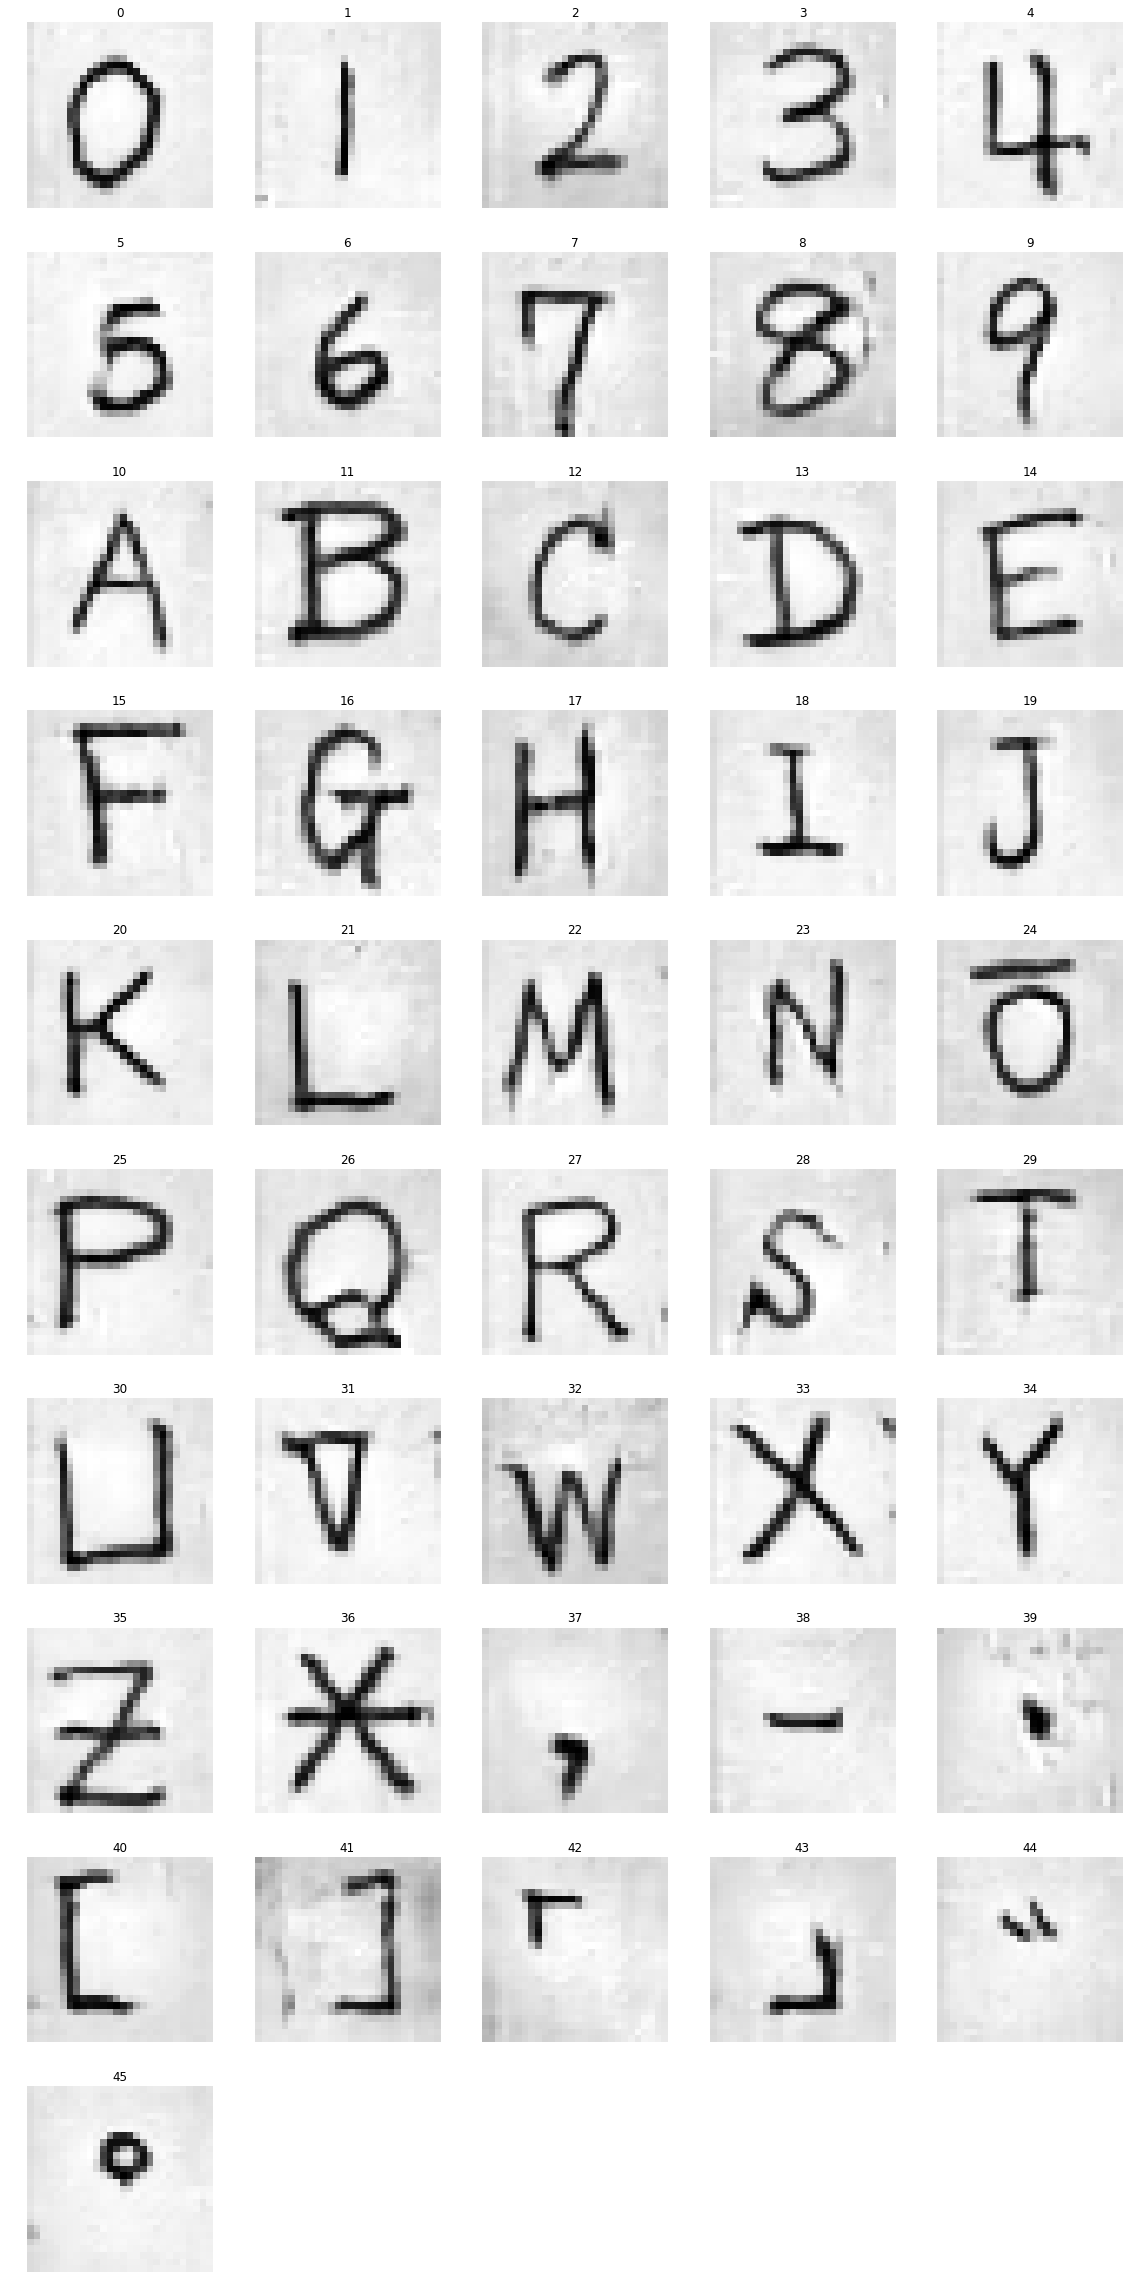

In [6]:
##### generator.predict時 #####
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

is_max = 0.0
is_min = 10000.0
reps = 100
for rep in range(reps):
    generated_images = gen_imgs_conditional()
    incep_score = calc_inception_score(generated_images)
    print('***** inception_score(num=46) = ', incep_score)
    if incep_score > is_max:
        is_max = incep_score
        gen_imgs_max = generated_images
    if incep_score < is_min:
        is_min = incep_score
        gen_imgs_min = generated_images

print()
print('reps=', reps, '***** Max score ***** inception_score(num=', Nlabel, ') = ', is_max)
generated_images = gen_imgs_max
plot_conditional()
print()
print('reps=', reps, '***** Min score ***** inception_score(num=', Nlabel, ') = ', is_min)
generated_images = gen_imgs_min
plot_conditional()

In [15]:
print(generated_images.shape)

(46, 28, 28, 1)


## Checkクイズ

- 問題1
    - 今回実装したConditional GANに関して、次の選択肢から不適切なものを一つ選びなさい
- 選択肢
    1. Conditional GANは生成する画像の数字を制御出来る。
    2. Generatorにラベルyを付与する。
    3. Discriminatorにラベルyを付与する。
    4. 潜在変数zを変えると生成する画像の数字も変わる。

- 問題2
    - Conditional GANとして最も適切なものを一つ選びなさい
-  選択肢
    1. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x|y)] +E_{z{\sim}p_{data}(z)}[\log(1-D(G(z|y)))]$
    2. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x)] +E_{z{\sim}p_{data}(z)}[\log(1-D(G(z)))]$
    3. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x|y)] +E_{z{\sim}p_{data}(z)}[\log(1-D(G(z)))]$
    4. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(y)] +E_{z{\sim}p_{data}(z)}[\log(1-D(G(z|y)))]$